In [1]:
!pip install -q rasterio  # -q is for quiet installation, non-verbose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.4 MB/s eta 0:00:00:00:0100:01


## Imports

In [2]:
import os
import torch
import numpy as np
import rasterio
import glob
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Parameters

In [3]:
base_path = '/kaggle/input/sentinel2-crop-mapping'
regions = ['lombardia', 'lombardia2']  # Lombardia3 is not being used for training and validation
years = ['data2016', 'data2017', 'data2018']  # data2019 is not being used for training and validation

num_timesteps = 32  # Due to variable timesteps in each year, in each region, only first 32 timesteps are taken
batch_size = 64

## Dataset Preprocessing and Loading

In [4]:
class Sentinel2Dataset(torch.utils.data.Dataset):
    def __init__(self, tile_dirs, num_timesteps=32, transform=None):
        """
            Args:
                tile_dirs (list of str): List of paths to tile folders
                num_timestpes (int): Number of timesteps to use (e.g, 32)
                transform: Optional transform to apply to input and mask
        """

        self.tile_dirs = tile_dirs
        self.num_timesteps = num_timesteps
        self.transform = transform

    def __len__(self):
        return len(self.tile_dirs)

    def __getitem__(self, idx):
        tile_dir = self.tile_dirs[idx]

        # List all .tif files that are not MSAVI or y.tif
        tif_files = sorted([
            f for f in os.listdir(tile_dir)
            if f.endswith('.tif') and '_MSAVI' not in f and f!='y.tif'
        ])

        # Take the first num_timesteps
        selected_files = tif_files[:self.num_timesteps]

        # Load and stack all 9 band images
        img_stack = []
        for fname in selected_files:
            with rasterio.open(os.path.join(tile_dir, fname)) as src:
                img = src.read()  # Shape: (9, 48, 48)
                img_stack.append(img)

        # Stack into shape (9, 32, 48, 48) and then reshape to (9x32, 48, 48)
        img_tensor = np.stack(img_stack, axis=1)     # (Band, T, H, W)
        img_tensor = img_tensor.reshape(-1, 48, 48)  # (Band*T, H, W)

        # Load the ground-truth mask (y.tif)
        with rasterio.open(os.path.join(tile_dir, 'y.tif')) as src:
            mask = src.read(1)  # Shape: (1, 48, 48), since single channel

        # Convert to torch tensor
        img_tensor = torch.tensor(img_tensor, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.long)
        mask_tensor[mask_tensor >= 20] = 255  # Mark invalid classes

        if self.transform:
            img_tensor, mask_tensor = self.transform(img_tensor, mask_tensor)

        return img_tensor, mask_tensor

In [5]:
# Collect all tile folder paths from regions/years
tile_dirs = []
for region in regions:
    for year in years:
        tile_dirs += glob.glob(os.path.join(base_path, region, year, '*'))

# Shuffle and split
train_tile_dirs, val_tile_dirs = train_test_split(
    tile_dirs,
    test_size = 0.2,
    random_state = 42
)

# Print lengths
print(f"Total tiles: {len(tile_dirs)}")
print(f"Train tiles: {len(train_tile_dirs)}")
print(f"Val tiles:   {len(val_tile_dirs)}")

# Create dataset
train_dataset = Sentinel2Dataset(train_tile_dirs, num_timesteps = num_timesteps)
val_dataset = Sentinel2Dataset(val_tile_dirs, num_timesteps = num_timesteps)

print(f'Length of Train Dataset: {len(train_dataset)}')
print(f'Length of Val Dataset: {len(val_dataset)}')

# Create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True,
                                              num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True,
                                             num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True)

Total tiles: 19969
Train tiles: 15975
Val tiles:   3994
Length of Train Dataset: 15975
Length of Val Dataset: 3994


-> Shape of the input is (9*32, 48, 48) and of output is (48, 48) with batch size of 8.

Train Sample:
x_train shape: torch.Size([288, 48, 48])
y_train shape: torch.Size([48, 48])
x_train dtype: torch.float32
y_train unique labels: tensor([  2,   7,   9,  11,  17, 255])


/tmp/ipykernel_36/2134571626.py:5: RuntimeWarning: invalid value encountered in divide
  return np.clip((band - p2) / (p98 - p2), 0, 1)
/usr/local/lib/python3.11/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


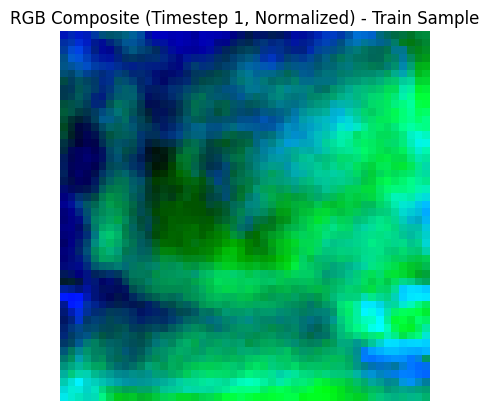

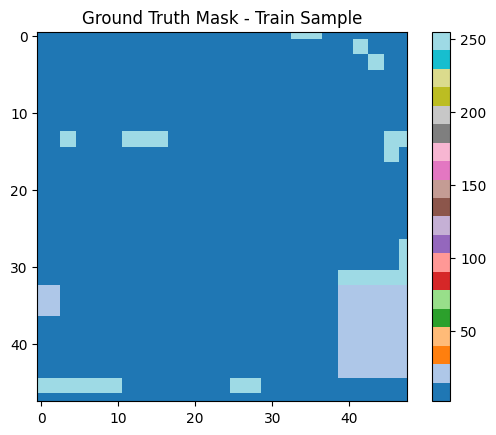


Validation Sample:
x_val shape: torch.Size([288, 48, 48])
y_val shape: torch.Size([48, 48])
x_val dtype: torch.float32
y_val unique labels: tensor([  7,   9,  11,  17, 255])


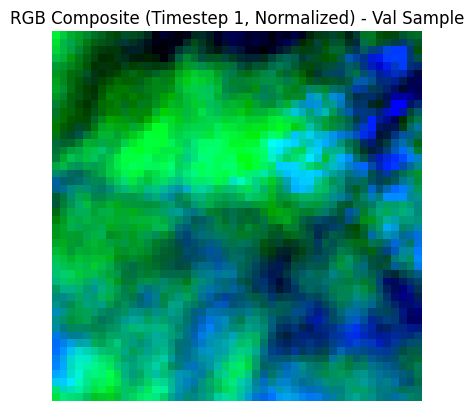

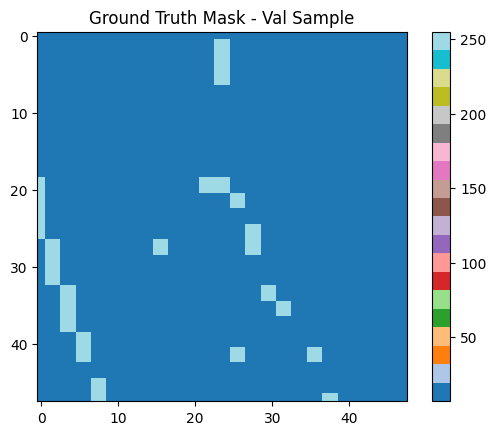

In [6]:
# Visualizing the images (rgb composite for multispectral input)
def normalize_band(band):
    """Contrast stretch to 2–98 percentile"""
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)
    

# Print from train dataset
x_train, y_train = train_dataset[0]
print("Train Sample:")
print(f"x_train shape: {x_train.shape}")  # Expected: (288, 48, 48)
print(f"y_train shape: {y_train.shape}")  # Expected: (48, 48)")
print(f"x_train dtype: {x_train.dtype}")
print(f"y_train unique labels: {torch.unique(y_train)}")  # Sanity check

# Extract bands 4, 3, 2 from timestep 1
b2 = 1   # Blue
b3 = 2   # Green
b4 = 3   # Red

rgb = x_train[[b4, b3, b2]]  # Shape: (3, 48, 48)

r = normalize_band(rgb[0].numpy())
g = normalize_band(rgb[1].numpy())
b = normalize_band(rgb[2].numpy())

rgb_normalized = np.stack([r, g, b], axis=-1)

# Show corrected image
plt.imshow(rgb_normalized)
plt.title("RGB Composite (Timestep 1, Normalized) - Train Sample")
plt.axis("off")
plt.show()

# Show mask
plt.imshow(y_train, cmap='tab20')
plt.title("Ground Truth Mask - Train Sample")
plt.colorbar()
plt.show()



# Print from val dataset
x_val, y_val = val_dataset[0]
print("\nValidation Sample:")
print(f"x_val shape: {x_val.shape}")  # Expected: (288, 48, 48)
print(f"y_val shape: {y_val.shape}")  # Expected: (48, 48)")
print(f"x_val dtype: {x_val.dtype}")
print(f"y_val unique labels: {torch.unique(y_val)}")


# For Val data
rgb = x_val[[b4, b3, b2]]  # Shape: (3, 48, 48)

r = normalize_band(rgb[0].numpy())
g = normalize_band(rgb[1].numpy())
b = normalize_band(rgb[2].numpy())

rgb_normalized = np.stack([r, g, b], axis=-1)

# Show corrected image
plt.imshow(rgb_normalized)
plt.title("RGB Composite (Timestep 1, Normalized) - Val Sample")
plt.axis("off")
plt.show()

# Show mask
plt.imshow(y_val, cmap='tab20')
plt.title("Ground Truth Mask - Val Sample")
plt.colorbar()
plt.show()

## 2D-CNN Model 

In [7]:
in_channels = 288  # 9*32
num_classes = 20

lenet_5 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, 6, kernel_size=5, padding=2), # C1: Conv (5x5), 6 filters:  (288 → 6), output: (6, 44, 44)
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),    # S1: Avg Pooling (2x2): output: (6, 22, 22)

    torch.nn.Conv2d(6, 16, kernel_size=5, padding=2),          # C2: Conv (5x5), 16 filters: output: (16, 18, 18)
    torch.nn.Tanh(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),    # S2: Avg Pooling (2x2): output: (16, 9, 9)

    torch.nn.Conv2d(16, num_classes, kernel_size=1),        # output: (20, 9, 9) — segmentation logits
    torch.nn.Upsample(size=(48, 48), mode='bilinear', align_corners=False)  # Upsample to (48, 48)
)

print(lenet_5)

Sequential(
  (0): Conv2d(288, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 20, kernel_size=(1, 1), stride=(1, 1))
  (7): Upsample(size=(48, 48), mode='bilinear')
)


-> The FC layers are removed and instead a Conv2D layer is used since we want the 2D segmentation map and FC layers flatten the 2d in 1d.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = lenet_5.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(lenet_5.parameters(), lr=0.01)

Using device: cuda


In [ ]:
def calculate_pixel_accuracy(pred, target):
    """
    Calculating pixel-wise accuracy by comparing the predicted class per pixel with the 
    ground truth and compute how many pixels were correctly classified.
    
    pred: tensor of shape (B, C, H, W) - raw logits
    target: tensor of shape (B, H, W) - class labels 
    """

    with torch.no_grad():
        pred_labels = torch.argmax(pred, dim=1)  # (B, H, W)
        correct = (pred_labels == target).float()
        accuracy = correct.sum() / correct.numel()
        return accuracy.item()


# Training step
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for x, y in tqdm(loader, desc='Training'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)  # (B, 20, 48, 48)
        
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += calculate_pixel_accuracy(out, y)

    avg_loss = running_loss / len(loader)
    avg_accuracy = running_accuracy / len(loader)

    return avg_loss, avg_accuracy


# Validation step
def validate_one_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        for x, y in tqdm(loader, desc='Validating'):
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            
            running_loss += loss.item()
            running_accuracy = calculate_pixel_accuracy(out, y)

    avg_loss = running_loss / len(loader)
    avg_accuracy = running_accuracy / len(loader)

    return avg_loss, avg_accuracy

In [12]:
# Train loop
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, optimizer, criterion)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

Training:   4%|▍         | 11/250 [00:49<17:47,  4.47s/it] 


NotADirectoryError: Caught NotADirectoryError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_36/3788693029.py", line 22, in __getitem__
    f for f in os.listdir(tile_dir)
               ^^^^^^^^^^^^^^^^^^^^
NotADirectoryError: [Errno 20] Not a directory: '/kaggle/input/sentinel2-crop-mapping/lombardia/data2018/tmplist2'


In [ ]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    x, y = dataset[idx]
    x = x.unsqueeze(0).to(device)  # Add batch dim

    with torch.no_grad():
        pred = model(x)  # (1, 20, 48, 48)
        pred_mask = pred.argmax(dim=1).squeeze().cpu()  # (48, 48)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(y, cmap='tab20')
    axs[0].set_title("Ground Truth")
    axs[1].imshow(pred_mask, cmap='tab20')
    axs[1].set_title("Predicted Mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Try on train and val
visualize_prediction(model, train_dataset, idx=0)
visualize_prediction(model, val_dataset, idx=0)

<hr>